<a href="https://colab.research.google.com/github/Avinandan22/logistic-regression/blob/master/ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch,torchvision
from torch import *
from torchvision import *
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset = torchvision.datasets.CIFAR10('./cifar10_data',train = True,download = True,transform = trans)
test_dataset = torchvision.datasets.CIFAR10('./cifar10_data',train = False,download = True,transform = trans)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batchsize = 128
valid_size = 0.1
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [0]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=False,sampler = train_sampler,pin_memory = True)
valid_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=False,sampler = valid_sampler,pin_memory = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

In [0]:
#creating a class for ResNets
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #just a ReLu
    self.RELU = nn.Sequential(nn.ReLU())
    #1st convolution layer
    self.layer1 = nn.Sequential(nn.Conv2d(3,16,3,stride = 1,padding = 1),nn.ReLU())
    #1st of the 3 stacks
    self.stack1 = nn.Sequential(nn.Conv2d(16,16,3,stride = 1,padding = 1),nn.ReLU())
    self.stack1short = nn.Sequential(nn.Conv2d(16,16,3,stride = 1,padding = 1))
    #stack1 to stack2 downsampling
    self.trans1 = nn.Sequential(nn.Conv2d(16,32,3,stride = 2,padding = 1),nn.ReLU())
    #2nd of 3 stacks
    self.stack2 = nn.Sequential(nn.Conv2d(32,32,3,stride = 1,padding = 1),nn.ReLU())
    self.stack2short = nn.Sequential(nn.Conv2d(32,32,3,stride = 1,padding = 1))
    #stack2 to stack3 downsampling
    self.trans2 = nn.Sequential(nn.Conv2d(32,64,3,stride = 2,padding = 1),nn.ReLU())
    #last stack
    self.stack3 = nn.Sequential(nn.Conv2d(64,64,3,stride = 1,padding = 1),nn.ReLU())
    self.stack3short = nn.Sequential(nn.Conv2d(64,64,3,stride = 1,padding = 1))
    #the average pooling step
    self.avg = nn.Sequential(nn.AvgPool2d(8))
  def forward(self, x):
      out = self.layer1(x)
      temp = out
      for i in range (3): # n = 3 for the entire training model
        out = self.stack1(out)
        out = self.stack1short(out)
        #making a skip connection before applying relu
        out = self.RELU(out + temp)
        temp = out
      out = self.trans1(out)
      temp = out
      for i in range (3):
        out = self.stack2(out)
        out = self.stack2short(out)
        out = self.RELU(out + temp)
        temp = out
      out = self.trans2(out)
      temp = out
      for i in range (3):
        out = self.stack3(out)
        out = self.stack3short(out)
        out = self.RELU(out + temp)
        temp = out
      out = self.avg(out)
      out = out.reshape(out.size(0),-1)
      out = self.RELU(out) #need a softmax
      return out

In [0]:
#a class for plain CNN
class notresnet(nn.Module):
  def __init__(self):
    super(notresnet,self).__init__()
    self.RELU = nn.Sequential(nn.ReLU())
    self.layer1 = nn.Sequential(nn.Conv2d(3,16,3,stride = 1,padding = 1),nn.ReLU())
    self.stack1 = nn.Sequential(nn.Conv2d(16,16,3,stride = 1,padding = 1),nn.ReLU())
    self.trans1 = nn.Sequential(nn.Conv2d(16,32,3,stride = 2,padding = 1),nn.ReLU())
    self.stack2 = nn.Sequential(nn.Conv2d(32,32,3,stride = 1,padding = 1),nn.ReLU())
    self.trans2 = nn.Sequential(nn.Conv2d(32,64,3,stride = 2,padding = 1),nn.ReLU())
    self.stack3 = nn.Sequential(nn.Conv2d(64,64,3,stride = 1,padding = 1),nn.ReLU())
    self.avg = nn.Sequential(nn.AvgPool2d(8))
  def forward(self,x):
    out = self.layer1(x)
    for i in range(2):
      out =  self.stack1(out) 
    out = self.trans1(out)
    for i in range(2):
      out =  self.stack2(out) 
    out = self.trans2(out)
    for i in range(2):
      out =  self.stack3(out)
    out = self.avg(out)
    out = out.reshape(out.size(0),-1)
    out = self.RELU(out)
    return out

In [0]:
#initializing the plain CNN
nores = notresnet()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_nrs = optim.SGD(nores.parameters(),lr = 0.1 ,momentum = 0.9,weight_decay = 0.0001)
loss_history_nrs = []
accuracy_val_history_nrs = []

In [0]:
#initializing the ResNet
net = Net()
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.01 ,momentum = 0.9,weight_decay = 0.0001)
loss_history = []
accuracy_val_history = []

In [0]:
#loading checkpoints from drive
nrs_model_save_name = 'nrsepoch30'
nrs_optim_save_name = 'nrsoptim30.pt'
nrs_loss_save_name = 'nrsloss30.pt'
nrs_acc_save_name = 'nrsacc30.pt'
model_save_name = 'epoch30.pt'
optim_save_name = 'optim30.pt'
loss_save_name = 'loss30.pt'
acc_save_name = 'acc30.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
path1 = F"/content/gdrive/My Drive/{optim_save_name}"
path2 = F"/content/gdrive/My Drive/{loss_save_name}"
path3 = F"/content/gdrive/My Drive/{acc_save_name}"
npath = F"/content/gdrive/My Drive/{nrs_model_save_name}"
npath1 = F"/content/gdrive/My Drive/{nrs_optim_save_name}"
npath2 = F"/content/gdrive/My Drive/{nrs_loss_save_name}"
npath3 = F"/content/gdrive/My Drive/{nrs_acc_save_name}"
net.load_state_dict(torch.load(path))
optimizer.load_state_dict(torch.load(path1))
loss_history = torch.load(path2) 
accuracy_val_history = torch.load(path3)
nores.load_state_dict(torch.load(npath))
optimizer_nrs.load_state_dict(torch.load(npath1))
loss_history_nrs = torch.load(npath2)
accuracy_val_history_nrs = torch.load(npath3)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#training the ResNet
for epoch in range(8):
  run_loss = 0.0
  for i,(inputs,labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    run_loss += loss.item()
    if i % 20 == 19:
      print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, run_loss/20))
      loss_history.append(run_loss)
      run_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for data in valid_loader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 5000 validation images: %d %%' % (100 * correct / total))
        accuracy_val_history.append(100 * correct / total)
print ('Finish')

[1,    20] loss: 0.504
Accuracy of the network on the 5000 validation images: 75 %
[1,    40] loss: 0.498
Accuracy of the network on the 5000 validation images: 76 %
[1,    60] loss: 0.466
Accuracy of the network on the 5000 validation images: 75 %
[1,    80] loss: 0.476
Accuracy of the network on the 5000 validation images: 75 %
[1,   100] loss: 0.495
Accuracy of the network on the 5000 validation images: 73 %
[1,   120] loss: 0.525
Accuracy of the network on the 5000 validation images: 73 %
[1,   140] loss: 0.581
Accuracy of the network on the 5000 validation images: 74 %
[1,   160] loss: 0.546
Accuracy of the network on the 5000 validation images: 74 %
[1,   180] loss: 0.557
Accuracy of the network on the 5000 validation images: 75 %
[1,   200] loss: 0.513
Accuracy of the network on the 5000 validation images: 75 %
[1,   220] loss: 0.541
Accuracy of the network on the 5000 validation images: 74 %
[1,   240] loss: 0.538
Accuracy of the network on the 5000 validation images: 75 %
[1, 

In [0]:
#training the plain net
for epoch in range(29):
  run_loss = 0.0
  for i,(inputs,labels) in enumerate(train_loader):
    optimizer_nrs.zero_grad()
    outputs = nores(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer_nrs.step()
    run_loss += loss.item()
    if i % 20 == 19:
      print('[%d, %5d] loss: %.3f'%(epoch + 1, i + 1, run_loss/20))
      loss_history_nrs.append(run_loss)
      run_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for data in valid_loader:
          images, labels = data
          outputs = nores(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the 5000 validation images: %d %%' % (100 * correct / total))
        accuracy_val_history_nrs.append(100 * correct / total)
print ('Finish')

[1,    20] loss: 1.736
Accuracy of the network on the 5000 validation images: 37 %
[1,    40] loss: 1.680
Accuracy of the network on the 5000 validation images: 36 %
[1,    60] loss: 1.616
Accuracy of the network on the 5000 validation images: 36 %
[1,    80] loss: 1.637
Accuracy of the network on the 5000 validation images: 42 %
[1,   100] loss: 1.613
Accuracy of the network on the 5000 validation images: 41 %
[1,   120] loss: 1.559
Accuracy of the network on the 5000 validation images: 40 %
[1,   140] loss: 1.578
Accuracy of the network on the 5000 validation images: 42 %
[1,   160] loss: 1.564
Accuracy of the network on the 5000 validation images: 43 %
[1,   180] loss: 1.509
Accuracy of the network on the 5000 validation images: 44 %
[1,   200] loss: 1.518
Accuracy of the network on the 5000 validation images: 41 %
[1,   220] loss: 1.527
Accuracy of the network on the 5000 validation images: 42 %
[1,   240] loss: 1.470
Accuracy of the network on the 5000 validation images: 44 %
[1, 

In [0]:
#saving to drive
nrs_model_save_name = 'nrsepoch30'
nrs_optim_save_name = 'nrsoptim30.pt'
nrs_loss_save_name = 'nrsloss30.pt'
nrs_acc_save_name = 'nrsacc30.pt'
model_save_name = 'epoch30.pt'
optim_save_name = 'optim30.pt'
loss_save_name = 'loss30.pt'
acc_save_name = 'acc30.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
path1 = F"/content/gdrive/My Drive/{optim_save_name}"
path2 = F"/content/gdrive/My Drive/{loss_save_name}"
path3 = F"/content/gdrive/My Drive/{acc_save_name}"
npath = F"/content/gdrive/My Drive/{nrs_model_save_name}"
npath1 = F"/content/gdrive/My Drive/{nrs_optim_save_name}"
npath2 = F"/content/gdrive/My Drive/{nrs_loss_save_name}"
npath3 = F"/content/gdrive/My Drive/{nrs_acc_save_name}"
torch.save(net.state_dict(), path)
torch.save(optimizer.state_dict(), path1)
torch.save(loss_history,path2)
torch.save(accuracy_val_history,path3)
torch.save(nores.state_dict(), npath)
torch.save(optimizer_nrs.state_dict(), npath1)
torch.save(loss_history,npath2)
torch.save(accuracy_val_history,npath3)

In [0]:
#checking accuracy for ResNet on test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 75 %


In [0]:
#checking accuracy for NOResNet on test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = nores(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network without res net on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network without res net on the 10000 test images: 73 %


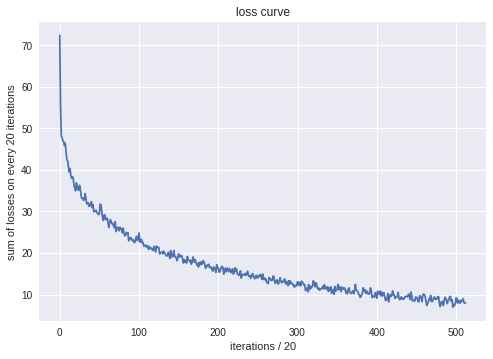

In [0]:
#loss curve
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.ylabel('sum of losses on every 20 iterations')
plt.xlabel('iterations / 20')
plt.title('loss curve')
plt.show()

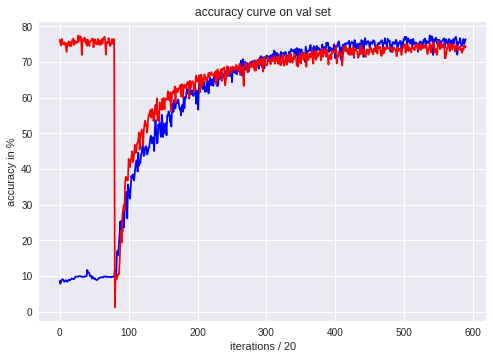

590

In [0]:
#accuracy curve on validation set
t = list(range(590))
plt.plot(t,accuracy_val_history,'b')
plt.plot(t,accuracy_val_history_nrs[510:1100],'r')
plt.ylabel('accuracy in %')
plt.xlabel('iterations / 20')
plt.title('accuracy curve on val set')
plt.show()
len(accuracy_val_history)

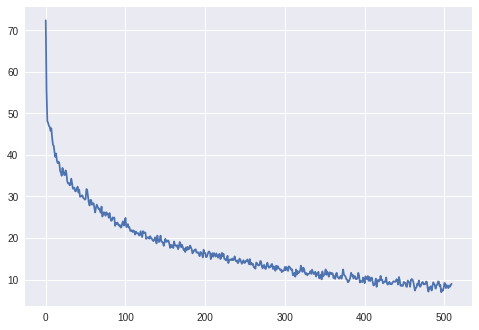

513

In [0]:
plt.plot(loss_history_nrs[:510])
plt.show()
len(loss_history_nrs)
len(loss_history)

The architecture looks like this
        

*   A Cnn layer to convert 32 * 32  * 3 sized imgages to 32 * 32 * 16
*   2 * n Cnn layers maintaining 32  * 32 * 16  sized images
     1.   each pair of these 2n layers has the skip connection
*   downsampling to 16 * 16 * 32 sized miages
*   2 * n Cnn layers maintaining 16 * 16 * 32 sized images
    1.   each pair of these 2n layers has the skip connection
*   downsampling to 8 * 8 * 64 sized images
*   2 * n Cnn layers maintaing 8 * 8 * 64 sized images
    1.   each pair of these 2n layers has the skip connection
*   gloabl  avg pooling resulting 1 * 1 * 64
*   reshaping and fully connected layer














ResNet was trained with n = 3
At the end of 22 epochs accuracy on validation set was around 73- 76% and even at around 30 epochs it was same
Thus at the end of 30 epochs of training,got an accuracy of 75% on Test Set
PlainNet was trained with n = 1(n = 3 always somehow got stuck in a local minima..i think so)
i have plotted the accuracy curves one on top of the other,they seem to be quite similar with thew resnet slightly better on the val set,probably if we train both longer and hypertune parameters,better differences will be visible. Also the accuracy on test set with plain nets with n = 1 is 73% which is 2% lower than with resnets